In [1]:
%matplotlib notebook
from CG import *

In [2]:
A = np.matrix([[3.0, 2.0], [2.0, 6.0]])
b = np.matrix([[2.0], [-8.0]])
c = 0.0
x = np.matrix([[-2.0], [-2.0]])

## B. Canned Algorithms <a id="B"></a>

The code given in this section represents efficient implementations of the algorithms discussed in this article. *Note, these have been converted from the original pseudocode to Python functions by AvS.*

### B.1 Steepest Descent <a id="B.1"></a>

Given the inputs ```A, b```, a starting value ```x```, a maximum number of iterations ```imax```, and an error tolerance ```epsilon``` <1:

In [3]:
def SD(A, b, x, imax=10, epsilon = 0.01):
    steps=np.asarray(x)
    i = 0
    r = b - A * x
    delta = r.T * r
    delta0 = delta
    while i < imax and delta > epsilon**2 * delta0:
        q = A * r
        alpha = float(delta / (r.T * q))
        x = x + alpha * r
        if i%50 == 0:
            r = b - A * x
        else:
            r = r - alpha * q
        delta = r.T * r
        i = i + 1
        steps = np.append(steps, np.asarray(x), axis=1)
    return steps

<IPython.core.display.Javascript object>


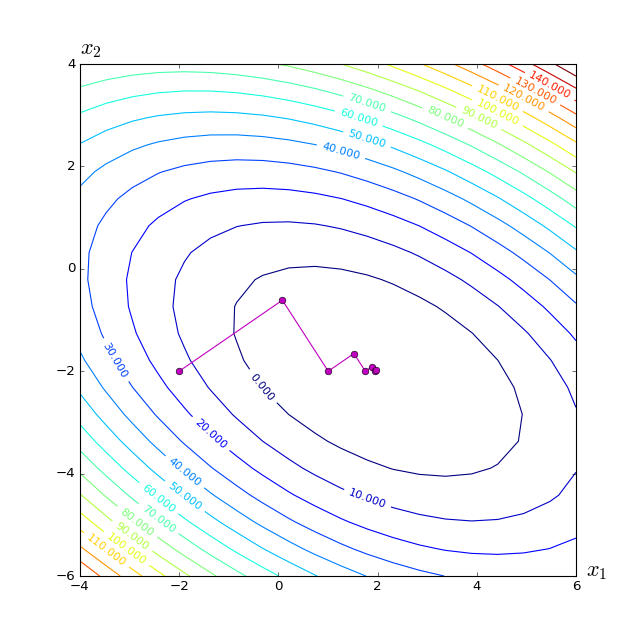

In [4]:
steps = SD(A,b,x)

fig = plt.figure(figsize=(8,8), num='Figure B.1')
plotcontours(A, b, c, fig)
plt.plot(steps[0,:], steps[1,:], '-mo');

This algorithm terminates when the maximum number of iterations ```imax``` has been exceeded, or when $\|r_{[i]}\| \leq $ ``` epsilon``` $\|r_{[0]}\|$.

The fast recursive formula for the residual is usually used, but once every 50 iterations, the exact residual is recalculated to remove accumulated floating point error. Of course, the number 50 is arbitrary; for large $n, \sqrt{n}$ might be appropriate. If the tolerance is large, the residual need not be corrected at all (in practice, this correction is rarely used). If the tolerance is close to the limits of the floating point precision of the machine, a test should be added after ```delta``` is evaluated to check if ```delta <= epsilon**2 * delta0```, and if this test holds true, the exact residual should also be recomputed and ```delta``` reevaluated. This prevents the procedure from terminating early due to floating point roundoff error.

### B.2 Conjugate Gradients <a id="B.2"></a>

Given the inputs ```A, b```, a starting value ```x```, a maximum number of iterations ```imax```, and an error tolerance ```epsilon``` < 1:

In [5]:
def CG(A, b, x, imax=10, epsilon = 0.01):
    steps=np.asarray(x)
    i = 0
    r = b - A * x
    d = r.copy()
    delta_new = r.T * r
    delta_0 = delta_new
    while i < imax and delta_new > epsilon**2 * delta_0:
        q = A * d
        alpha = float(delta_new / (d.T * q))
        x = x + alpha * d
        if i%50 == 0:
            r = b - A * x
        else:
            r = r - alpha * q
        delta_old = delta_new
        delta_new = r.T * r
        beta = float(delta_new / delta_old)
        d = r + beta * d
        i = i + 1
        steps = np.append(steps, np.asarray(x), axis=1)
    return steps


<IPython.core.display.Javascript object>


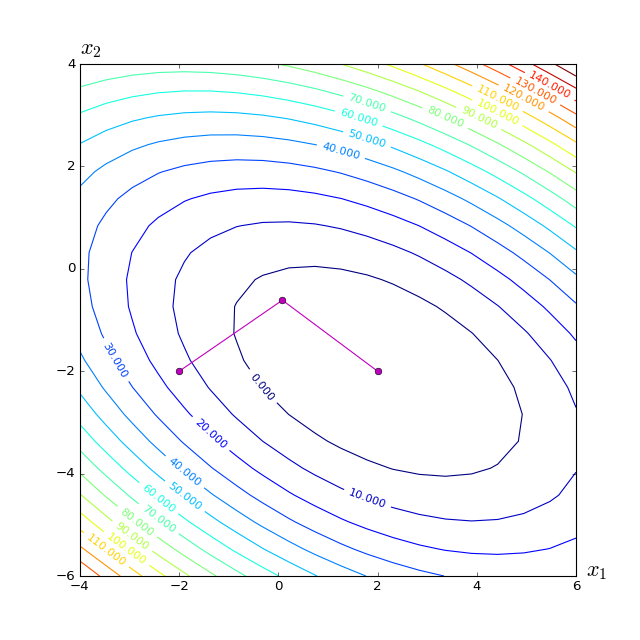

In [6]:
steps = CG(A,b,x)

fig = plt.figure(figsize=(8,8), num='Figure B.2')
plotcontours(A, b, c, fig)
plt.plot(steps[0,:], steps[1,:], '-mo');

See the comments at the end of Section B1.

### B.3 Preconditioned Conjugate Gradients <a id="B.3"></a>

Given the inputs ```A, b```, a starting value ```x```, the inverse of a (perhaps implicitly defined) preconditioner ```M```, a maximum number of iterations ```imax```, and an error tolerance ```epsilon``` < 1:

In [7]:
def PCG(A, b, x, M_inv, imax=10, epsilon = 0.01):
    steps=np.asarray(x)
    i = 0
    r = b - A * x
    d = M_inv * r
    delta_new = r.T * d
    delta_0 = delta_new
    while i < imax and delta_new > epsilon**2 * delta_0:
        q = A * d
        alpha = float(delta_new / (d.T * q))
        x = x + alpha * d
        if i%50 == 0:
            r = b - A * x
        else:
            r = r - alpha * q
        s = M_inv * r
        delta_old = delta_new
        delta_new = r.T * s
        beta = float(delta_new / delta_old)
        d = s + beta * d
        i = i + 1
        steps = np.append(steps, np.asarray(x), axis=1)
    return steps

<IPython.core.display.Javascript object>


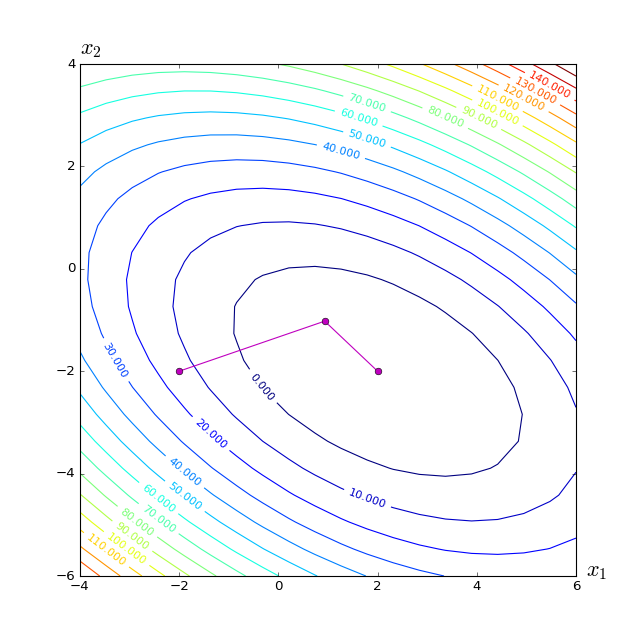

In [8]:
M_inv = np.matrix([[1/3.0, 0], [0, 1/6.0]])
steps = PCG(A,b,x,M_inv)

fig = plt.figure(figsize=(8,8), num='Figure B.3')
plotcontours(A, b, c, fig)
plt.plot(steps[0,:], steps[1,:], '-mo');

The statement “```s = M_inv * r```” implies that one should apply the preconditioner, which may not actually be in the form of a matrix.

See also the comments at the end of Section B1.

### B.4 Nonlinear Conjugate Gradients with Newton-Raphson and Fletcher-Reeves <a id="B.4"></a>

Given a function $f$, it's derivative ```df```, and second derivative ```ddf```, a starting value ```x```, a maximum number of CG iterations ```imax```, a CG error tolerance ```epsilon``` < 1, a maximum number of Newton-Raphson iterations ```jmax```, a Newton-Raphson error tolerance ```eps``` < 1, and a restart number ```n```:

In [ ]:
# THIS CODE HAS NOT BEEN TESTED
def NCG_NRFR(df, ddf, x, imax=10, epsilon = 0.01, jmax=10, eps = 0.01, n=50):
    # df and ddf must be callable functions
    steps=np.asarray(x)
    i = 0
    k = 0
    r = -df(x)
    d = r.copy()
    delta_new = r.T * r
    delta_0 = delta_new
    while i < imax and delta_new > epsilon**2 * delta0:
        j = 0
        delta_d = d.T * d
        alpha = - float(df(x).T * d / (d.T * ddf(x) * d))
        while j < jmax and alpha**2 * delta_d > eps**2:            
            x = x + alpha * d
            j = j + 1
            alpha = - float(df(x).T * d / (d.T * ddf(x) * d))
        r = - df(x)
        delta_old = delta_new
        delta_new = r.T * r
        beta = float(delta_new / delta_old)
        d = r + beta * d
        k = k + 1
        if k==n or r.T * d<=0:
            d = r.copy()
            k = 0
        i = i + 1
        steps = np.append(steps, np.asarray(x), axis=1)
    return steps

This algorithm terminates when the maximum number of iterations ```imax``` has been exceeded, or when $\|r_{[i]}\| \leq$ ``` epsilon``` $r\|_{[0]}\|$.

Each Newton-Raphson iteration adds ```alpha*d``` to ```x```; the iterations are terminated when each update ```alpha*d``` falls below a given tolerance (||```alpha*d```|| $\leq$ ```eps```), or when the number of iterations exceeds ```jmax```. A fast inexact line search can be accomplished by using a small ```jmax``` and/or by approximating the Hessian ```ddf(x)``` with its diagonal.

Nonlinear CG is restarted (by setting ```d = r```) whenever a search direction is computed that is not a descent direction. It is also restarted once every $n$ iterations, to improve convergence for small $n$.

The calculation of ```alpha``` may result in a divide-by-zero error. This may occur because the starting point ```x``` is not sufficiently close to the desired minimum, or because is not twice continuously differentiable. In the former case, the solution is to choose a better starting point or a more sophisticated line search. In the latter case, CG might not be the most appropriate minimization algorithm.

### B.5 Preconditioned Nonlinear Conjugate Gradients with Secant and Polak-Ribière <a id="B.5"></a>

Given a function $f$, it's derivative ```df```, the inverse ```M_inv``` of preconditioner $M \approx f''(x)$, a starting value ```x```, a maximum number of CG iterations ```imax```, a CG error tolerance ```epsilon``` < 1, a Secant method step parameter ```sigma0```, a maximum number of Secant method iterations ```jmax```, and a Secant method error tolerance ```eps``` < 1:

In [ ]:
# THIS CODE HAS NOT BEEN TESTED
def PNCG_SPR(df, M_inv, x, imax=10, epsilon = 0.01, sigma0=0.1, jmax=10, eps = 0.01):
    # df and M_inv must be callable functions
    steps=np.asarray(x)
    i = 0
    k = 0
    r = -df(x)
    s = M_inv(x) * r
    d = s.copy()
    delta_new = r.T * d
    delta_0 = delta_new
    while i < imax and delta_new > epsilon**2 * delta0:
        j = 0
        delta_d = d.T * d
        alpha = -sigma0
        eta_prev = df(x + sigma0*d).T * d
        while j < jmax and alpha**2 * delta_d > eps**2:
            eta = df(x).T * d
            alpha = alpha * (eta / (eta_prev - eta))
            x = x + alpha * d
            eta_prev = eta
            j = j + 1
        r = - df(x)
        delta_old = delta_new
        delta_mid = r.T * s
        beta = float((delta_new - delta_mid) / delta_old)
        k = k + 1
        if k==n or beta<=0:
            d = s.copy()
            k = 0
        else:
            d = s + beta * d
        i = i + 1
        steps = np.append(steps, np.asarray(x), axis=1)
    return steps

This algorithm terminates when the maximum number of iterations ```imax``` has been exceeded, or when $\|r_{[i]}\| \leq$ ``` epsilon```$\|r_{[0]}\|$.

Each Secant method iteration adds ```alpha*d``` to ```x```; the iterations are terminated when each update ```a*d``` falls below a given tolerance (```||a*d|| <= eps```), or when the number of iterations exceeds ```jmax```. A fast inexact line search can be accomplished by using a small ```jmax```. The parameter ```sigma0``` determines the value of $\sigma$ in Equation 59 for the first step of each Secant method minimization. Unfortunately, it may be necessary to adjust this parameter 
to achieve convergence.

The Polak-Ribière ```beta``` parameter is $\frac{\delta_{new} - \delta_{mid}}{\delta_old} = \frac{r^T_{[i+1]}s_{[i+1]} - r^T_{[i+1]}s_{[i]}}{r^T_{[i]}s_{[i]}} = \frac{r^T_{[i+1]}M^{-1}(r_{[i+1]} - r_{[i]})}{r^T_{[i]}M^{-1}r_{[i]}}$. Care must be taken that the preconditioner is always positive-definite. The preconditioner is not necessarily in the form of a matrix.

Nonlinear CG is restarted (by setting ```d = r.copy()```) whenever the Polak-Ribière parameter ```beta``` is negative. It is also restarted once every ```n``` iterations, to improve convergence for small ```n```.

Nonlinear CG presents several choices: Preconditioned or not, Newton-Raphson method or Secant method or another method, Fletcher-Reeves or Polak-Ribière. It should be possible to construct any of the variations from the versions presented above. (Polak-Ribière is almost always to be preferred.)

Next: [C. Ugly Proofs](CGC.ipynb)